In [1]:
import numpy as np 
import pandas as pd 

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, LSTM, Reshape ,Input, BatchNormalization, MaxPooling2D, Activation, Dense, Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
data = pd.read_csv('C:/Users/murat/Desktop/duygu_analizi/fer-rafdb.csv')

In [6]:
x_data = data['pixels']
y_data = data['emotion']

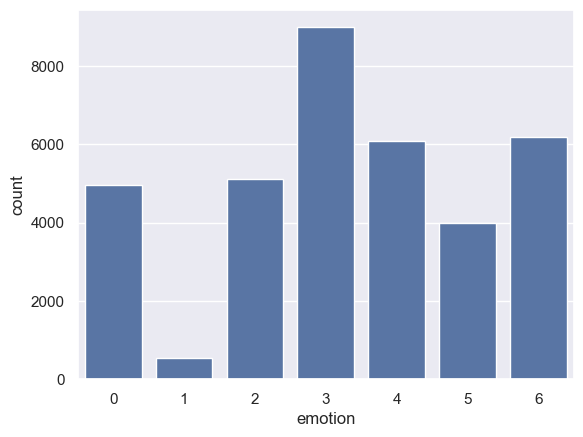

In [7]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

In [8]:
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


In [9]:
y_data.value_counts()

emotion
0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: count, dtype: int64

In [10]:
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    208 207 205 206 207 207 210 211 210 207 211 21...
62919    124 59 30 34 31 32 34 34 38 38 35 30 27 31 36 ...
62920    109 114 103 97 100 79 61 74 82 67 48 62 73 87 ...
62921    50 55 68 70 65 65 56 55 62 67 70 82 91 102 116...
62922    84 83 79 67 53 46 39 45 46 53 70 79 80 83 99 1...
Length: 62923, dtype: object

In [12]:
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [13]:
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(62923, 48, 48, 1)

In [14]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

In [23]:
model = Sequential([
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Reshape((-1,128)),
    (LSTM(128)),
    (Reshape((-1,64))),
    LSTM(64),
#     (Reshape((-1,64)))
#     (LSTM(32))    
    Dense(200, activation='relu'),
    Dropout(0.6),
    Dense(7, activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 46, 46, 64)        0

In [24]:
tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes = True, show_dtype = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [25]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# SGD optimizer ile başlangıç öğrenme oranı belirleniyor
optimizer = SGD(learning_rate=0.0005, momentum=0.9, nesterov=True)

# ModelCheckpoint callback'i
checkpoint = ModelCheckpoint(
    filepath='C:/Users/murat/Desktop/duygu_analizi/best_model_2.h5',      # En iyi modeli kaydetmek için dosya yolu
    monitor='val_accuracy',        # Doğrulama doğruluğunu izler
    save_best_only=True,           # Sadece en iyi modeli kaydeder
    mode='max',                    # Maksimum doğruluk hedeflenir
    verbose=1
)

# ReduceLROnPlateau callback'i
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',            # Doğrulama kaybını izler
    factor=0.5,                    # Öğrenme oranını yarıya indirir
    patience=5,                    # 5 epoch boyunca iyileşme olmazsa devreye girer
    min_lr=1e-6,                   # Minimum öğrenme oranı
    verbose=1
)
# Modelin derlenmesi
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
y_train = np_utils.to_categorical(y_train, 7)
y_train.shape

(56630, 7)

In [27]:
y_test = np_utils.to_categorical(y_test, 7)
y_test.shape

(6293, 7)

In [37]:
# Modeli eğitme
history = model.fit(
    x_train, y_train,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint,reduce_lr]  # ModelCheckpoint'i callback olarak ekle
)

Epoch 1/100
1770/1770 [==============================] - ETA: 0s - loss: 1.5793 - accuracy: 0.3750
Epoch 1: val_accuracy improved from -inf to 0.45622, saving model to C:/Users/murat/Desktop/duygu_analizi\best_model_2.h5
1770/1770 [==============================] - 329s 184ms/step - loss: 1.5793 - accuracy: 0.3750 - val_loss: 1.4012 - val_accuracy: 0.4562 - lr: 0.0100
Epoch 2/100
1770/1770 [==============================] - ETA: 0s - loss: 1.1505 - accuracy: 0.5525
Epoch 2: val_accuracy improved from 0.45622 to 0.55665, saving model to C:/Users/murat/Desktop/duygu_analizi\best_model_2.h5
1770/1770 [==============================] - 313s 177ms/step - loss: 1.1505 - accuracy: 0.5525 - val_loss: 1.1389 - val_accuracy: 0.5567 - lr: 0.0100
Epoch 3/100
1770/1770 [==============================] - ETA: 0s - loss: 0.9951 - accuracy: 0.6170
Epoch 3: val_accuracy improved from 0.55665 to 0.60861, saving model to C:/Users/murat/Desktop/duygu_analizi\best_model_2.h5
1770/1770 [====================

KeyboardInterrupt: 

In [39]:
print("Accuracy of our model on validation data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

197/197 [==============================] - 8s 41ms/step - loss: 1.1209 - accuracy: 0.8529
Accuracy of our model on validation data :  85.28524041175842 %


In [85]:

cm = plt.figure(figsize = (4,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
cm.savefig("model_acc")
plt.show()

NameError: name 'history' is not defined

<Figure size 400x400 with 0 Axes>

In [87]:
# summarize history for loss
cm = plt.figure(figsize = (4,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
cm.savefig("model_loss")
plt.show()

NameError: name 'history' is not defined

<Figure size 400x400 with 0 Axes>

In [89]:
y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

197/197 [==============================] - 14s 46ms/step


[6, 5, 0, 6, 1, 0, 6, 4, 1, 6]

In [90]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[6, 5, 5, 6, 1, 0, 3, 4, 1, 3]

In [91]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.79      0.84      0.82       935
           1       0.98      1.00      0.99       895
           2       0.84      0.76      0.80       880
           3       0.82      0.81      0.82       906
           4       0.79      0.68      0.73       888
           5       0.86      0.97      0.91       869
           6       0.77      0.80      0.78       920

    accuracy                           0.84      6293
   macro avg       0.84      0.84      0.84      6293
weighted avg       0.84      0.84      0.84      6293



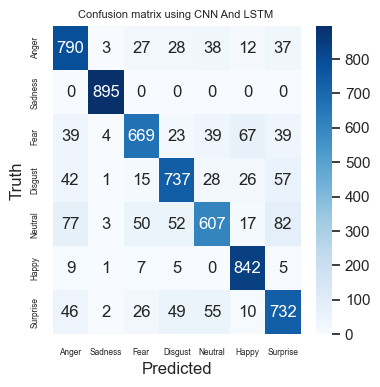

In [92]:
# import seaborn as sn
# cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

# plt.figure(figsize = (6,4))
# sn.heatmap(cm,cmap="Purples", annot = True, fmt = 'd')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.savefig("confusion")

import seaborn as sn
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (4,4))
ax = plt.axes()
sn.heatmap(cm,cmap="Blues", annot = True, fmt = 'd')
ax.xaxis.set_ticklabels([  "Anger", "Sadness", "Fear", "Disgust", "Neutral","Happy","Surprise"], fontsize=6);
ax.yaxis.set_ticklabels([  "Anger", "Sadness", "Fear", "Disgust", "Neutral","Happy","Surprise"],  fontsize=6);

plt.title('Confusion matrix using CNN And LSTM ', fontsize = 8, fontweight=500)
plt.xlabel('Predicted')
plt.ylabel('Truth')


plt.savefig("confusion")